# Topic modelling:

From the resulted dataset that includes tweets related to the start-up ecosystem, we will find the topics that twitter users discuss about. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import unicodedata
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import word_tokenize, sent_tokenize, FreqDist, pos_tag
from nltk.corpus import stopwords, wordnet
from collections import defaultdict
import spacy
nlp = spacy.load('en_core_web_sm')
import itertools

# LDA
!pip install gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim import corpora, models
from gensim.models import Phrases
from gensim.corpora import Dictionary
!pip install tqdm
import tqdm
import multiprocessing
from gensim.utils import simple_preprocess



: 

## Some data preparation

In [5]:
#import the dataset 
start_ups = pd.read_csv('start.csv',index_col=0)

In [4]:
pd.set_option('display.max_columns', None)

##### Missing values: 
- there are  missing values in the columns of text_for_topic, text_for_sent and hashtags. 
- This is not a problem because different features were selected previously for topic modelling and sentiment analysis respectively
- Also, many tweets do not have a hashtag. 
- For hashtag based topic modelling, we will use only tweets with hashtags and we will implement LDA on each hashtag of each tweet

In [6]:
np.sum(start_ups.isnull())

tweet                 0
created_at            0
text_topic          120
text_sentiment        2
token_topic           0
token_sentiment       2
topic_lemma         230
hashtags           7812
unigrams              0
bigrams               0
dtype: int64

In [8]:
start_ups.dropna( how='any',
                  subset=['text_topic','text_sentiment','token_sentiment',
                          'topic_lemma'], inplace= True)

In [9]:
len(start_ups)

12020

In [10]:
start_ups.to_csv('start_ups.csv', index= False)

## 1. LDA topic modelling:

- create the baseline LDA model on the original tweets including only proper nouns and nouns
- create the hashtag based LDA model performed on the hashtags column

### 1.1 Baseline LDA:
- compute coherence score for a range of topics number to find the optimal number of topics
- perform LDA on the column destined for topic modelling with only nouns and proper nouns

In [11]:
seed = 123
np.random.seed(seed)

#create the necessary input documents for the LDA
processed_docs = start_ups["topic_lemma"].apply(lambda x: word_tokenize(x)) # tokenize

dictionary = gensim.corpora.Dictionary(processed_docs) # make dictionary for all the words (words converted to ids)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=None) # pruning dictionary to reduce noise

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs] # For each document, create a dictionary reporting how many words and how many times those words appear

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


In [12]:
seed = 123
np.random.seed(seed)
#Compute the coherence score for a range of number of topics.
coherence = []
for k in range(1,20):
    print('Round: '+str(k))
    Lda = gensim.models.LdaMulticore
    ldamodel = Lda(corpus_tfidf, num_topics=k, id2word = dictionary, workers=4, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=processed_docs,
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19


In [14]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

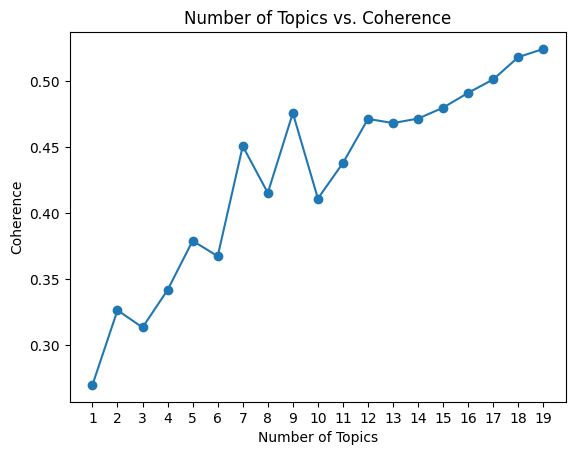

In [16]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

#### Please note that because LDA is a probabilistic model, even if we set random seed for getting the same results, the results might be differ a bit

In [17]:
seed = 123
np.random.seed(seed)
#the number of topics was set to   based on the above coherence score plot.
ldamodel = Lda(corpus_tfidf, num_topics=11, id2word = dictionary, workers=4, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} Words: {}'.format(idx, topic))

Topic: 0 Words: 0.021*"lagos" + 0.015*"hub" + 0.014*"summit" + 0.012*"state" + 0.012*"innovation" + 0.012*"business" + 0.011*"day" + 0.010*"silicon" + 0.010*"accelerator" + 0.010*"program"
Topic: 1 Words: 0.022*"kenya" + 0.017*"ecosystem" + 0.017*"ghana" + 0.016*"south" + 0.014*"launches" + 0.013*"news" + 0.011*"google" + 0.011*"bill" + 0.010*"people" + 0.009*"industry"
Topic: 2 Words: 0.031*"funding" + 0.029*"post" + 0.022*"govt" + 0.017*"seed" + 0.013*"year" + 0.012*"service" + 0.012*"report" + 0.012*"oil" + 0.012*"investment" + 0.011*"commerce"
Topic: 3 Words: 0.068*"post" + 0.025*"capital" + 0.021*"health" + 0.019*"bank" + 0.019*"buhari" + 0.016*"venture" + 0.014*"power" + 0.014*"sector" + 0.011*"lagos" + 0.011*"firm"


In [17]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score of baseline LDA model: ', coherence_lda)


Coherence Score of baseline LDA model:  0.5242410932548471


### 1.1 Hashtag-based LDA topic modelling:
- compute coherence score for a range of topics number to find the optimal number of topics
- perform hashtag based LDA on the column destined for topic modelling with only the hashtags

In [6]:
import ast

tags = start_ups['hashtags'].dropna().unique().tolist()
tags = [ast.literal_eval(tag) for tag in tags]

# Flatten the list of tokenized hashtags
flat_tags = [tag for sublist in tags for tag in sublist]

# Tokenize the hashtags
token_tags = [word_tokenize(tag) for tag in flat_tags]

In [7]:
seed = 123
np.random.seed(seed)
# Create a dictionary from the tokenized documents
tag_dictionary = corpora.Dictionary(token_tags)
tag_dictionary.filter_extremes(no_below=15, no_above=0.7, keep_n=None)

# Convert tokenized documents to a bag-of-words corpus
bow_corpus_tag = [tag_dictionary.doc2bow(doc) for doc in token_tags]

# Create TF-IDF representation of the corpus
tfidf_tag = models.TfidfModel(bow_corpus_tag)
corpus_tag = tfidf_tag[bow_corpus_tag]

In [19]:
seed = 123
np.random.seed(seed)
#Compute the coherence score for a range of number of topics.
coherence = []
for k in range(3,15):
    print('Round: '+str(k))
    lda_tag = gensim.models.LdaMulticore
    # LDA model using TF-IDF
    lda_model_tag = lda_tag(corpus_tag, num_topics=k, id2word=tag_dictionary,random_state=100,\
                                chunksize=10000, passes=40,per_word_topics=True, workers=4, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model_tag, texts=token_tags,
                                                     dictionary=tag_dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14


In [75]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

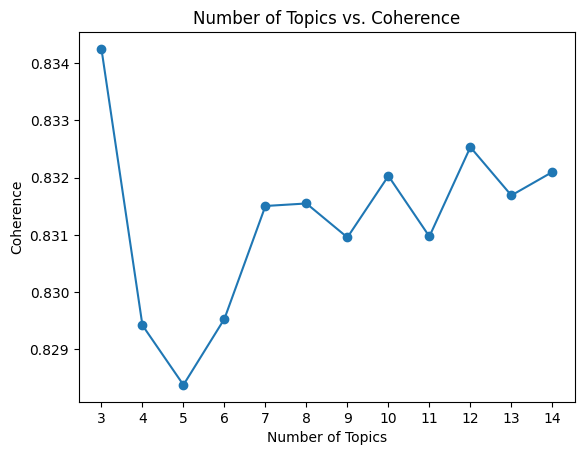

In [21]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

#### Please note that because LDA is a probabilistic model, even if we set random seed for getting the same results, the results might be differ a bit

In [8]:
seed = 123
np.random.seed(seed)
lda_tag = gensim.models.LdaMulticore
lda_model_tag = lda_tag(corpus_tag, num_topics=7, id2word=tag_dictionary,random_state=100,\
                                chunksize=10000, passes=40,per_word_topics=True, workers=4, eval_every = None)
print('hashtag-based LDA topics:')
for idx, topic in lda_model_tag.print_topics(-1):
    print('Topic: {} Words: {}'.format(idx, topic))

hashtag-based LDA topics:
Topic: 0 Words: 0.302*"lagos" + 0.141*"technews" + 0.111*"entrepreneurship" + 0.076*"investment" + 0.054*"developers" + 0.048*"portharcourt" + 0.039*"agriculture" + 0.039*"science" + 0.037*"ethiopia" + 0.031*"accelerator"
Topic: 1 Words: 0.147*"news" + 0.094*"teckexperts" + 0.092*"education" + 0.087*"socialmedia" + 0.078*"blockchain" + 0.058*"twitter" + 0.058*"g" + 0.051*"crypto" + 0.051*"analytics" + 0.045*"healthtech"
Topic: 2 Words: 0.317*"entrepreneur" + 0.189*"internet" + 0.077*"abuja" + 0.073*"apple" + 0.067*"developer" + 0.055*"covid" + 0.038*"ambition" + 0.034*"nairobi" + 0.034*"founders" + 0.034*"data"
Topic: 3 Words: 0.262*"business" + 0.199*"kenya" + 0.152*"fintech" + 0.098*"fact" + 0.055*"vc" + 0.054*"money" + 0.033*"edtech" + 0.028*"google" + 0.025*"leadership" + 0.021*"insta"
Topic: 4 Words: 0.230*"ghana" + 0.155*"online" + 0.128*"ai" + 0.088*"apps" + 0.044*"bitcoin" + 0.041*"designtwitter" + 0.039*"programmer" + 0.039*"zambia" + 0.035*"smwlagos"

In [26]:
seed = 123
np.random.seed(seed)

coherence_model_lda_tag = CoherenceModel(model=lda_model_tag, texts=token_tags, dictionary=tag_dictionary, coherence='c_v')
coherence_lda_tag = coherence_model_lda_tag.get_coherence()
print('Coherence Score of hashtag based LDA model: ', coherence_lda_tag)

Coherence Score of hashtag based LDA model:  0.8307028430256845


### 1.4 The most representative tweets per topic: 

In [23]:
seed = 123
np.random.seed(seed)

n_topics = 7
# Initialize a list to store the tweets for each topic
topic_tweets = [[] for _ in range(n_topics)]

# Iterate over the tweets and assign them to the corresponding topic
for i, tweet in enumerate(start_ups["tweet"]):
    bow_vector = tag_dictionary.doc2bow(word_tokenize(tweet))
    topic_probabilities = lda_model_tag.get_document_topics(bow_vector)

    # Find the dominant topic for the tweet
    dominant_topic = max(topic_probabilities, key=lambda x: x[1])[0]

    # Check if dominant_topic is within the range of topic_tweets
    if dominant_topic < n_topics:
        # Append the tweet and its topic probability to the corresponding topic's list
        topic_tweets[dominant_topic].append((tweet, topic_probabilities[dominant_topic][1]))

# Sort the tweets in each topic by their topic probabilities
for i, tweets in enumerate(topic_tweets):
    topic_tweets[i] = sorted(tweets, key=lambda x: x[1], reverse=True)[:20]  # Retrieve the top 20 tweets

# Print the 10 most representative tweets for each topic
for topic_id, tweets in enumerate(topic_tweets):
    print(f"Topic {topic_id}:")
    for tweet, _ in tweets:
        print(tweet)
    print()

Topic 0:
The UK-Nigeria Tech Hub Developer Placement Programme places 100 software developers in internships with 43 selected SMEs in Nigeria.   #technews #technologyafrica #technologynews #technewsafrica #africannews #startups #Uk #Nigeria #hub #internship  https://t.co/86l5qYM2HK
Calling all developers, product managers, and tech leaders!! 24 hours left to apply!! https://t.co/xDOSZnxCbH #tech #startup #nigeria #lagos https://t.co/dKgxYUarA7
The available investment in Nigeria's tech space doesn’t match the size of the sector. Many startups die at the lower rungs due to lack of investment #techpolicyng @thevpfoundation
Mycar Consurtium showcasing services under her subsidiary "Mycar HR solutions" . . . #cobalt #cobaltechnologies #Nigeria #africa #tech #startup #lagos #techcompany #software #Geek… https://t.co/dd6lufNrLE
@bukolasaraki @OfficialPDPNig @atiku @_walebakare @OluwoleOnemola @Onile050 @babastundey @BetterWithAtiku @babaidris090 @chiefow @SPNigeria “The report revealed that 

In [58]:
len(start_ups)

12020

### 1.5: Categorize each tweet to its corresponding topic:
- the tweets will be accessed from the column "token_sentiment" which will be used for sentiment analysis
- a new dataframe will be created with tweets and their corresponding topic

In [25]:
pd.set_option('display.max_colwidth', None)

In [43]:
seed = 123
np.random.seed(seed)

# Initialize an empty DataFrame
topic_df = pd.DataFrame(columns=['Tweet', 'Topic'])

for i, tweet in enumerate(start_ups['token_sentiment']):
    bow_vector = tag_dictionary.doc2bow(word_tokenize(tweet))
    topic_probabilities = lda_model_tag.get_document_topics(bow_vector)

    # Find the dominant topic for the tweet
    dominant_topic = max(topic_probabilities, key=lambda x: x[1])[0]

    # Check if dominant_topic is within the range of topic_tweets
    if dominant_topic < 7:
        # Create a new DataFrame with the current tweet and topic
        new_row = pd.DataFrame({'Tweet': [tweet], 'Topic': [dominant_topic]})

        # Concatenate the new row with the existing DataFrame
        topic_df = pd.concat([topic_df, new_row], ignore_index=True)
     

In [45]:
topic_df.to_csv('topic_tweets.csv', index= False)

### 1.6: Visualize topics over time

In [9]:
documents = [' '.join(tag_dictionary[id] for id, _ in doc) for doc in corpus_tag]

In [10]:
documents, dates = zip(*[(doc, date) for doc, date in zip(documents, start_ups["created_at"].values) if doc.strip() != ''])

In [11]:
len(documents)

4222

In [12]:
len(dates)

4222

### 1.6: Topics overtime:
- find the average number of topics for each year
- plot based on proportions

In [13]:
from lda_over_time.lda_over_time import LdaOverTime
from lda_over_time.models.temporal_lda_model import TemporalLdaModel

In [14]:
#
model = TemporalLdaModel(
    corpus=documents,                   # list texts to be analyzed
    dates=dates,                        # dates of each article
    date_format="%Y-%m-%d %H:%M:%S",    # date format is MM/DD/YYYY
    freq="1Y",                          # frequency of 1 year
    n_topics=7,                         # we want to get 7 topics
    aggregator="average"                # average of each year
)

In [15]:
main = LdaOverTime(model)

In [16]:
for topic_id in range(1, 8):
    print(
        main.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=10               # we want the top 10 words for each topic
        )
    )

['lagos', 'technews', 'investment', 'bitcoin', 'ethiopia', 'software', 'hub', 'accelerator', 'techstartups', 'bigdata']
['entrepreneurship', 'news', 'blockchain', 'money', 'education', 'developers', 'socialmedia', 'twitter', 'healthtech', 'elitepath']
['entrepreneur', 'apple', 'abuja', 'developer', 'analytics', 'site', 'techforgood', 'nairobi', 'it', 'kenya']
['business', 'kenya', 'fintech', 'fact', 'vc', 'edtech', 'leadership', 'mondaymotivation', 'founders', 'google']
['ghana', 'online', 'apps', 'crypto', 'agriculture', 'agritech', 'science', 'techstartup', 'programmer', 'smwlagos']
['southafrica', 'didyouknow', 'internet', 'egypt', 'rwanda', 'uganda', 'growth', 'investors', 'portharcourt', 'uk']
['innovation', 'ai', 'teckexperts', 'entrepreneurs', 'g', 'designtwitter', 'endsars', 'covid', 'womenintech', 'binance']


In [17]:
main.rename_topics(
    [
        "Finance",
        "Sectors of involvement", 
        "Young entrepreneurs & education", 
        "Fintech & young tech talents", 
        "Internet usage & policies",
        "Guidance of starting a business",
        "Accelator Programms"
        
    ],
)

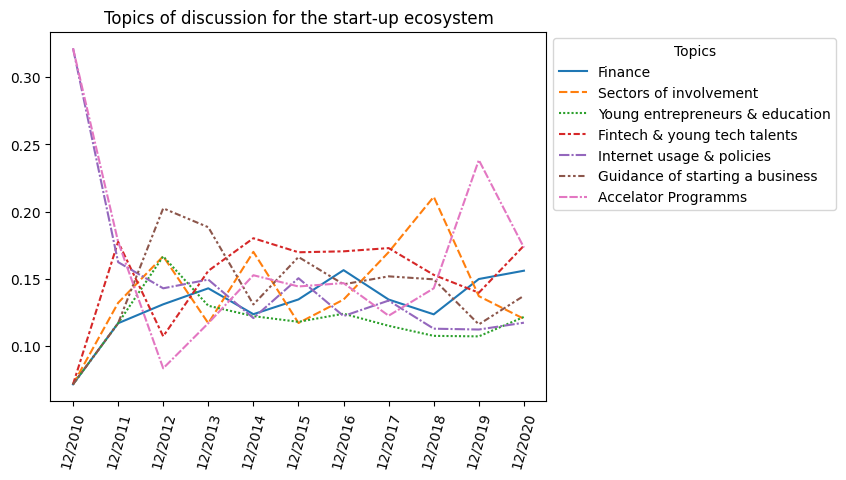

In [18]:
main.plot(
    title = 'Topics of discussion for the start-up ecosystem',    # Plot's title
    
    legend_title="Topics",     # Legend's title
    
    # path_to_save="./plot_of_news.png",   # Set location to save
    
    display=True,                # Display graph (default)
    
    rotation=75,                 # Rotate labels in 75º
    
    mode="line",                 # Plot lines (default)
    
    date_format="%m/%Y",      # Set custom date format to MM/YYYY
)

